# Kirk Evaluation Protocol 2.0
First, generate train and test contexts.
Then run commands down below.

## Create Train/Test Contexts

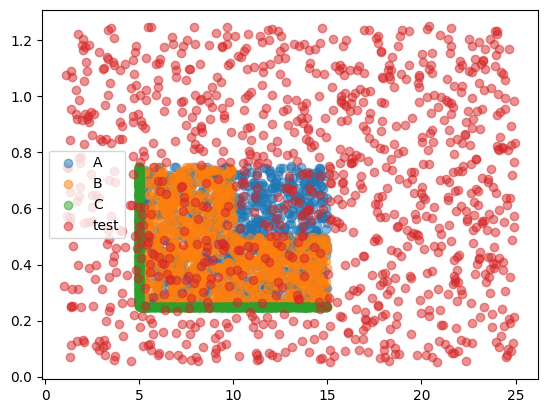

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from experiments.common.utils.json_utils import lazy_json_dump

 
env_name = "CARLCartPoleEnv"
seed = 6847
n_samples_train = 1000
n_samples_test = 1000

bounds = {
    "gravity": {
        "train": [5, 15],
        "test": [1, 25]
    },
    "pole_length": {
        "train": [0.25, 0.75],
        "test": [0.05, 1.25],
    }
}

outdir = Path("data/kirk_ep") / env_name
outdir.mkdir(exist_ok=True, parents=True)


def get_contexts(bounds: dict[str, dict[str, list[float]]], mode: str = "A", seed: int = None) -> tuple[dict, np.ndarray]:

    # Create train context set
    rng = np.random.default_rng(seed=seed)
    B = np.array([b["train"] for cf, b in bounds.items()])
    cfs = list(bounds.keys())
    contexts = {}
    if mode == "A":
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])
    elif mode == "B":
        n = n_samples_train // 3
        n2 = n_samples_train - n

        B_ = B.copy()
        B_[1, 1] = np.mean(B_[1])   
        x1 =  np.array([rng.uniform(*B_[i], size=n2) for i in range(len(B))])

        B_ = B.copy()
        B_[0, 1] = np.mean(B_[0])
        B_[1, 0] = np.mean(B_[1])
        x2 = np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])

        X = np.concatenate([x1, x2], axis=1)
    elif mode == "C":
        n = n_samples_train // 2

        X = []
        for i in range(len(B)):
            B_ = B.copy()
            B_[i, 1] = B_[i, 0]
            x =  np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])
            X.append(x)

        X = np.concatenate(X, axis=1)

    elif mode == "test":
        B = np.array([b["test"] for cf, b in bounds.items()])
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])

    else:
        raise NotImplementedError

    contexts = {i: {cf: X[j,i] for j, cf in enumerate(cfs)} for i in range(X.shape[1])}  

    return contexts, X

modes = ["A", "B", "C", "test"]


for mode in modes:
    contexts, X = get_contexts(bounds=bounds, mode=mode, seed=seed)

    lazy_json_dump(contexts, outdir / f"contexts_{mode}.json")

    plt.scatter(*X, label=mode, alpha=0.5)

plt.legend()
plt.show()




## Command

Run:
`python experiments/benchmarking/run_training.py +experiments=kirk_ep +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all,cgate_hadamard' -m `

Evaluate:
`python experiments/evaluation/run_evaluation.py 'n_eval_episodes_per_context=5' 'experiment=kirk_eval_ep' +experiments/ep/mode=test -m --result_dir '/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-17/07-52-33_benchmark_train'`

In [33]:
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-17/13-25-22"
]

import pandas as pd
import experiments.evaluation.loading
from importlib import reload
reload(experiments.evaluation.loading)


rpc_fn = outdir / "rpc.csv"
reload = True

df = pd.concat([experiments.evaluation.loading.load(folder_eval=folder_eval, rpc_fn=rpc_fn, load_from_path=experiments.evaluation.loading.load_from_path_eval, reload_rpc=reload) for folder_eval in folders_eval]).reset_index(drop=True)


from rich import print as printr

In [37]:
cfs = list(bounds.keys())
n_bins = 50
cf_bins = {}
for cf in cfs:
    bin_idx, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True, labels=False)
    labels, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True)
    cf_bins[cf] = bins
    df[cf + "_bin_idx"] = bin_idx
    df[cf + "_bin_lbl"] = labels

    


In [51]:
from scipy.stats import trim_mean
import seaborn as sns

hm_long = df.groupby(by=[cf + "_bin_idx" for cf in cfs]+ ["visibility"]).apply(lambda x: trim_mean(x["return"], proportiontocut=0.25))

hm = hm_long.to_numpy()
hm.shape[0] // 2
len(cf_bins[cf])
printr(df[cf + "_bin_idx"].nunique())
printr(hm.shape)
printr(hm_long)



50

(4151,)

gravity_bin_idx  pole_length_bin_idx  visibility    
0                0                    cgate_hadamard    373.454094
                                      concat (all)      491.115385
                                      hidden            500.000000
                 1                    cgate_hadamard    407.105000
                                      hidden            500.000000
                                                           ...    
49               38                   concat (all)      500.000000
                                      hidden            497.615385
                 46                   cgate_hadamard    473.695652
                                      concat (all)      500.000000
                                      hidden            438.153846
Length: 4151, dtype: float64